In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
import pickle

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter
# import data_creation_pipeline as dcp
# import compute_biased_pks_fields as cpk

%load_ext autoreload
%autoreload 2

2024-09-02 06:41:25.132163: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-02 06:41:27.479819: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-02 06:41:27.489201: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-02 06:41:47.037887: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-02 06:42:14.634686: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

In [2]:
idx_LH_str = '0663'
sim_name_quijote = f'quijote_LH{idx_LH_str}'

dir_data = '/cosmos_storage/home/mpelle/Yin_data/Quijote'
fn_params = f'{dir_data}/LH{idx_LH_str}/param_{idx_LH_str}.txt'
param_vals = np.loadtxt(fn_params)
param_names = ['omega_m', 'omega_baryon', 'h', 'n_s', 'sigma_8']
param_dict = dict(zip(param_names, param_vals))
param_dict['tau'] = 0.0952 # ?? TODO check proper tau to be using!! 
cosmo_quijote = utils.get_cosmo(param_dict)

Param neutrino_mass not in param dict, adding quijote value
Param w0 not in param dict, adding quijote value
Param wa not in param dict, adding quijote value


In [3]:
box_size = 1000.

## Make LR simulation, bias model

In [4]:
n_grid = 512

ngenic_phases = True
phase_type = 1

seed = int(idx_LH_str)
expfactor = 1.0
FixedInitialAmplitude = False

sim_2lpt, disp_2lpt = bacco.utils.create_lpt_simulation(cosmo_quijote, box_size, Nmesh=n_grid, Seed=seed,
                                                    FixedInitialAmplitude=FixedInitialAmplitude,InitialPhase=0, 
                                                    expfactor=expfactor, LPT_order=2, order_by_order=None,
                                                    phase_type=phase_type, ngenic_phases=ngenic_phases, return_disp=True, 
                                                    sphere_mode=0)

2024-09-02 06:42:53,626 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
2024-09-02 06:42:53,627 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
2024-09-02 06:42:53,628 bacco.sims : Initialising simulation Default
2024-09-02 06:42:53,629 bacco.sims : ...done in 0.00172 s


bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =48; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler: Computing 2LPT density...
l2=7.78209e-18 
l2=6.73432e-17 
l2=-3.85992e-17 
l2=-3.25662e-18 
l2=-4.83533e-17 
l2=-1.04121e-16 
bacco.lss_scaler: Fourier transforming second order source...
l2=-2.14211e-08 l3a=3.105e-08 l3b=4.34859e-08


2024-09-02 06:43:18,959 bacco.scaler : Adding displacement field with a vel-factor=53.391221


bacco.lss_scaler:  Adding LSS displacement: vel_factor=53.391221 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [6]:
dens_lin_2lpt = sim_2lpt.get_linear_field(ngrid=n_grid, quantity='delta', damping_scale=0.75)

bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =48; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


In [8]:
bmodel = bacco.BiasModel(sim=None, linear_delta=dens_lin_2lpt, ngrid=n_grid, ngrid1=None,
                        sdm=False, mode="dm", 
                        BoxSize=box_size,
                        npart_for_fake_sim=n_grid, 
                        bias_model='expansion', deposit_method="cic",
                        use_displacement_of_nn=False, interlacing=False,
                        )

2024-09-02 06:58:22,123 bacco.BiasModel : Initialising Bias Model class ...


In [13]:
bias_fields_lag = bmodel.bias_terms_lag()

2024-09-02 07:12:02,469 bacco.BiasModel : Computing delta_to_tidal_field with 48 threads...
2024-09-02 07:12:02,470 bacco.BiasModel : fttw plan
2024-09-02 07:12:02,485 bacco.BiasModel : fttw freqs
2024-09-02 07:12:02,486 bacco.BiasModel : tidk freqs
2024-09-02 07:14:02,823 bacco.BiasModel : ifft
2024-09-02 07:14:51,308 bacco.BiasModel : Computing laplacian ...
2024-09-02 07:14:51,312 bacco.BiasModel : Memory used: 33.380319232 Gigabytes
2024-09-02 07:18:29,157 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-09-02 07:18:29,161 bacco.BiasModel : Memory used: 34.448818176 Gigabytes
2024-09-02 07:18:29,419 bacco.BiasModel : Computing delta squared ...
2024-09-02 07:18:29,421 bacco.BiasModel : Memory used: 34.9855744 Gigabytes
2024-09-02 07:18:31,987 bacco.BiasModel : Computing tidal component G2 with the given tidal field
2024-09-02 07:18:31,988 bacco.BiasModel : Memory used: 36.05952512 Gigabytes


In [9]:
import readgadget

snapshot = '/dipc/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube/663/snapdir_004/snap_004'
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

# read positions, velocities and IDs of the particles
pos_raw = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
ids = readgadget.read_block(snapshot, "ID  ", ptype)-1   #IDs starting from 0

In [7]:
idx_LH = '663'
fn_lag_index = f"/cosmos_storage/data_sharing/quijote_{idx_LH}_neighfile.pickle"
with open(fn_lag_index, 'rb') as f:
    lag_index = pickle.load(f)
print(lag_index.shape)

(134217728,)


In [26]:
pos_LR = pos_raw[lag_index]

In [14]:
bias_terms_eul_LR =[]
for ii in range(0,len(bias_fields_lag)):
    bias_terms = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pos_LR, 
                            mass = (bias_fields_lag[ii]).flatten(), deposit_method='cic', 
                            interlacing=False)
    bias_terms_eul_LR.append(bias_terms)
bias_terms_eul_LR = np.array(bias_terms_eul_LR)

2024-09-02 07:20:56,744 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-02 07:20:57,150 bacco.statistics : starting deposit 1
2024-09-02 07:20:58,058 bacco.statistics :  mesh done in 1.31 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-09-02 07:20:59,327 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-02 07:20:59,726 bacco.statistics : starting deposit 1
2024-09-02 07:21:00,641 bacco.statistics :  mesh done in 1.31 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-09-02 07:21:01,876 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-02 07:21:02,286 bacco.statistics : starting deposit 1
2024-09-02 07:21:03,186 bacco.statistics :  mesh done in 1.31 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-09-02 07:21:04,344 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-02 07:21:04,743 bacco.statistics : starting deposit 1
2024-09-02 07:21:05,632 bacco.statistics :  mesh done in 1.29 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-09-02 07:21:06,797 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-02 07:21:07,208 bacco.statistics : starting deposit 1
2024-09-02 07:21:08,080 bacco.statistics :  mesh done in 1.28 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


## Same for HR, but dilute it to be same grid size

In [16]:
n_grid_HR = 1024

ngenic_phases = True
phase_type = 1

seed = int(idx_LH_str)
expfactor = 1.0
FixedInitialAmplitude = False

sim_2lpt_HRdil, disp_2lpt_HRdil = bacco.utils.create_lpt_simulation(cosmo_quijote, box_size, Nmesh=n_grid, Seed=seed,
                                                    FixedInitialAmplitude=FixedInitialAmplitude,InitialPhase=0, 
                                                    expfactor=expfactor, LPT_order=2, order_by_order=None,
                                                    phase_type=phase_type, ngenic_phases=ngenic_phases, return_disp=True, 
                                                    sphere_mode=0)

2024-09-02 07:25:19,471 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
2024-09-02 07:25:19,473 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
2024-09-02 07:25:19,474 bacco.sims : Initialising simulation Default
2024-09-02 07:25:19,474 bacco.sims : ...done in 0.00156 s


bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =48; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler: Computing 2LPT density...
l2=7.78209e-18 
l2=6.73432e-17 
l2=-3.85992e-17 
l2=-3.25662e-18 
l2=-4.83533e-17 
l2=-1.04121e-16 
bacco.lss_scaler: Fourier transforming second order source...
l2=-2.14211e-08 l3a=3.105e-08 l3b=4.34859e-08


2024-09-02 07:25:44,697 bacco.scaler : Adding displacement field with a vel-factor=53.391221


bacco.lss_scaler:  Adding LSS displacement: vel_factor=53.391221 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [17]:
dens_lin_2lpt_HRdil = sim_2lpt_HRdil.get_linear_field(ngrid=n_grid, quantity='delta', damping_scale=0.75)

bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =48; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


In [18]:
bmodel_HRdil = bacco.BiasModel(sim=None, linear_delta=dens_lin_2lpt_HRdil, ngrid=n_grid, ngrid1=None,
                        sdm=False, mode="dm", 
                        BoxSize=box_size,
                        npart_for_fake_sim=n_grid, 
                        bias_model='expansion', deposit_method="cic",
                        use_displacement_of_nn=False, interlacing=False,
                        )

2024-09-02 07:26:02,960 bacco.BiasModel : Initialising Bias Model class ...


In [19]:
bias_fields_lag_HRdil = bmodel_HRdil.bias_terms_lag()

2024-09-02 07:26:06,472 bacco.BiasModel : Computing delta_to_tidal_field with 48 threads...
2024-09-02 07:26:06,473 bacco.BiasModel : fttw plan
2024-09-02 07:26:06,474 bacco.BiasModel : Computing linear field ...
2024-09-02 07:26:06,475 bacco.BiasModel : Memory used: 30.170509312 Gigabytes
2024-09-02 07:26:06,488 bacco.BiasModel : fttw freqs
2024-09-02 07:26:06,489 bacco.BiasModel : tidk freqs
2024-09-02 07:28:05,879 bacco.BiasModel : ifft
2024-09-02 07:28:52,689 bacco.BiasModel : Computing laplacian ...
2024-09-02 07:28:52,691 bacco.BiasModel : Memory used: 39.839268864 Gigabytes
2024-09-02 07:32:27,769 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-09-02 07:32:27,772 bacco.BiasModel : Memory used: 40.906379264 Gigabytes
2024-09-02 07:32:28,030 bacco.BiasModel : Computing delta squared ...
2024-09-02 07:32:28,032 bacco.BiasModel : Memory used: 41.443332096 Gigabytes
2024-09-02 07:32:30,522 bacco.BiasModel : Computing tidal component G2 with the given tidal field


In [20]:
import readgadget

snapshot = '/dipc/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube_HR/663/snapdir_004/snap_004'
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

# read positions, velocities and IDs of the particles
pos_raw_HR = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
ids_HR = readgadget.read_block(snapshot, "ID  ", ptype)-1   #IDs starting from 0

In [21]:
idx_LH = '663'
fn_lag_index_HR = f"/cosmos_storage/data_sharing/quijote_{idx_LH}_HR_neighfile.pickle"
with open(fn_lag_index_HR, 'rb') as f:
    lag_index_HR = pickle.load(f)
print(lag_index_HR.shape)

(1073741824,)


In [22]:
pos_HR = pos_raw_HR[lag_index_HR]

In [24]:
pos_grid = pos_HR.reshape(n_grid_HR, n_grid_HR, n_grid_HR,3)

ndilution = 2
# _lag_index_HR = lag_index_HR.reshape(n_grid_HR,n_grid_HR, n_grid_HR)
# _lag_index_HR = lag_index_HR[::ndilution,::ndilution,::ndilution]
spos = pos_grid[::ndilution,::ndilution,::ndilution,:]
    
assert n_grid==n_grid_HR//ndilution
pos_HR_diluted = spos.reshape(n_grid**3, 3)
print(len(pos_HR_diluted))

134217728


In [34]:
bias_terms_eul_HRdil =[]
for ii in range(0,len(bias_fields_lag_HRdil)):
    bias_terms = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pos_HR_diluted, 
                            mass = (bias_fields_lag_HRdil[ii]).flatten(), deposit_method='cic', 
                            interlacing=False)
    bias_terms_eul_HRdil.append(bias_terms)
bias_terms_eul_HRdil = np.array(bias_terms_eul_HRdil)

2024-09-02 07:50:13,082 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-02 07:50:13,485 bacco.statistics : starting deposit 1
2024-09-02 07:50:14,362 bacco.statistics :  mesh done in 1.28 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-09-02 07:50:16,529 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-02 07:50:16,961 bacco.statistics : starting deposit 1
2024-09-02 07:50:17,865 bacco.statistics :  mesh done in 1.34 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-09-02 07:50:19,199 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-02 07:50:19,631 bacco.statistics : starting deposit 1
2024-09-02 07:50:20,493 bacco.statistics :  mesh done in 1.29 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-09-02 07:50:21,794 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-02 07:50:22,220 bacco.statistics : starting deposit 1
2024-09-02 07:50:23,110 bacco.statistics :  mesh done in 1.32 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-09-02 07:50:24,412 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-09-02 07:50:24,878 bacco.statistics : starting deposit 1
2024-09-02 07:50:25,744 bacco.statistics :  mesh done in 1.33 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


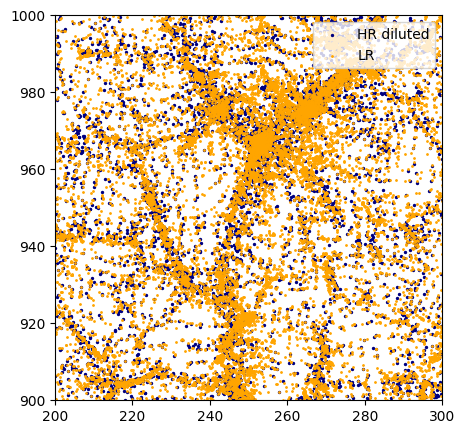

In [30]:
plt.figure(figsize=(5,5))
mask = (pos_HR_diluted[:,2] < 752) & (pos_HR_diluted[:,2] > 747) 
mask_LR = (pos_LR[:,2] < 755) & (pos_LR[:,2] > 745) 

plt.scatter(pos_HR_diluted[mask,0], pos_HR_diluted[mask,1],marker='o',s=2, color='navy', 
            label="HR diluted")
plt.scatter(pos_LR[mask_LR,0], pos_LR[mask_LR,1],marker='o',s=1, color='orange',
            label='LR')
plt.xlim([200,300]); plt.ylim([900,1000])
#plt.xlim([0,50]); plt.ylim([0,50])

plt.legend(loc='upper right')

In [35]:
dx_density = (bias_terms_eul_HRdil[1][0,:,:,:]-bias_terms_eul_LR[1][0,:,:,:]).flatten()

In [37]:
# fig, ax = plt.subplots(1,3, figsize=(10,4))
# labels = ['x', 'y', 'z']
# for axis in range(3):
#     ax[axis].hist(dx_density[:,axis],ls=':',#range=[-20,20], 
#                   bins=30)
#     ax.set_xlabel(rf'{labels[axis]}_\text{{HR,diluted}} - {labels[axis]}_\text{{LR}}')
    

Text(0, 0.5, '$\\Delta x, HRdiluted - LR$')

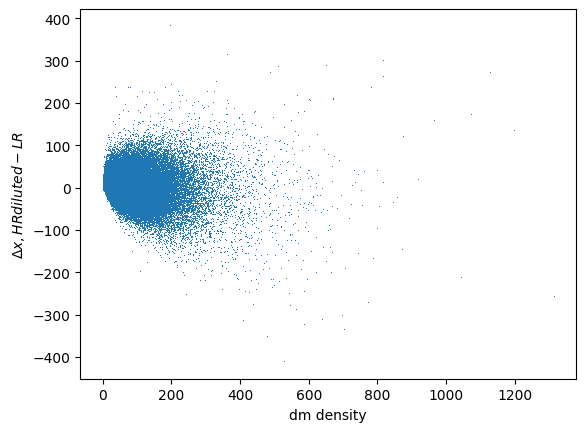

In [38]:
plt.plot(bias_terms_eul_LR[0].flatten(),dx_density,',')
plt.xlabel('dm density')
plt.ylabel(r'$\Delta x, HRdiluted - LR$')